<a href="https://www.kaggle.com/code/werakaggle/time-series-forecasting-methods-part-i?scriptVersionId=119680839" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


# Comparison  of the performances of time series forecasting methods

# Time series forecasting methods part I

## - Generation of synthetic non-stationary time series data 
## - Data pre-processing
## - AR, MA, ARMA, ARIMA and SARIMA statistical methods used for forecasting
## - Linear Regression used for forecasting

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression


In [2]:
# functions for later

# function that takes the arrays as input and create plots:
def plot_time_series(time, values, label):
    plt.figure(figsize=(20,6))
    plt.plot(time, values, color="cornflowerblue")
    plt.plot(time, df['values'], color='rebeccapurple')
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Values", fontsize=20)
    plt.title(label, fontsize=20)
    plt.grid(True)
    
    

# function to test data whether it's stationary or not

#define function for ADF test

# Test for stationarity: If the test statistic is greater than the critical value, we reject the null hypothesis (series is not stationary). 
#     If the test statistic is less than the critical value, if fail to reject the null hypothesis (series is stationary). 
#     For the air passenger data, the value of the test statistic is greater 
#     than the critical value at all confidence intervals, and hence we can say that the series is not stationary.
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries, dataName):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test on: ', dataName)
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
#define function for kpss test
# KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test
# Test for checking the stationarity of a time series (slightly less popular than the Dickey Fuller test)
# Null Hypothesis: The process is trend stationary.
# Alternate Hypothesis: The series has a unit root (series is not stationary).
    
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries, dataName):
    print ('Results of KPSS Test on: ', dataName)
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    


## 1. Generation of the non-stationary Time Series


See this notebook where it's sort of step by step of how we got here: https://www.kaggle.com/werakaggle/time-series-creating-synthetic-datasets )


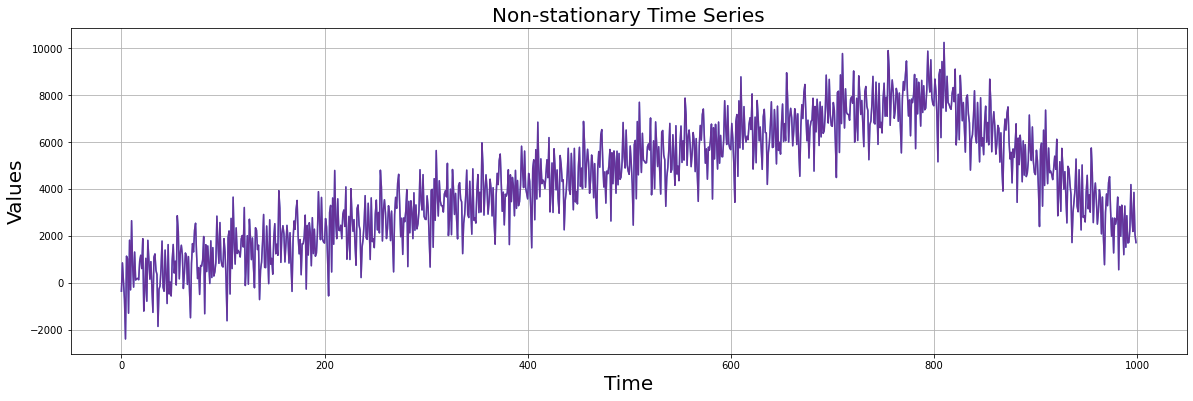

In [3]:
np.random.seed(6)

values = np.random.randn(200)*1000
seasonal = []
for i in range(10):   #10 seasons
    for j in range(100):
        seasonal.append(values[j])
        
noise = np.random.randn(1000)*100
seasonal += noise
seasonal_upward = seasonal + np.arange(1000)*10
big_event = np.zeros(1000)
big_event[-200:] = np.arange(200)*-40
non_stationary = seasonal_upward  + big_event
time = np.arange(1000)


# now get our synthetic data into a dataframe and set 
df = pd.DataFrame({'time': time,
                   'values': non_stationary})
df=df.set_index(['time'])

# and visualise it
plot_time_series(time, non_stationary, "Non-stationary Time Series")

Test for stationarity: If the test statistic is greater than the critical value, we reject the null hypothesis (series is not stationary). If the test statistic is less than the critical value, if fail to reject the null hypothesis (series is stationary). For the air passenger data, the value of the test statistic is greater than the critical value at all confidence intervals, and hence we can say that the series is not stationary.

#### ADF (Augmented Dickey Fuller) Test
Test to determine the presence of unit root in the series

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

In [4]:
#apply adf and kpss tests on the series
adf_test(df['values'], "values column")
kpss_test(df['values'], "values column")

Results of Dickey-Fuller Test on:  values column
Test Statistic                  -1.427379
p-value                          0.569082
#Lags Used                      21.000000
Number of Observations Used    978.000000
Critical Value (1%)             -3.437054
Critical Value (5%)             -2.864500
Critical Value (10%)            -2.568346
dtype: float64
Results of KPSS Test on:  values column
Test Statistic            3.525061
p-value                   0.010000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


the test statistic > critical value, which implies that the series is not stationary.

the ADF test has an alternate hypothesis of linear or difference stationary, while the KPSS test identifies trend-stationarity in a series.

#### step 2 - data pre processing

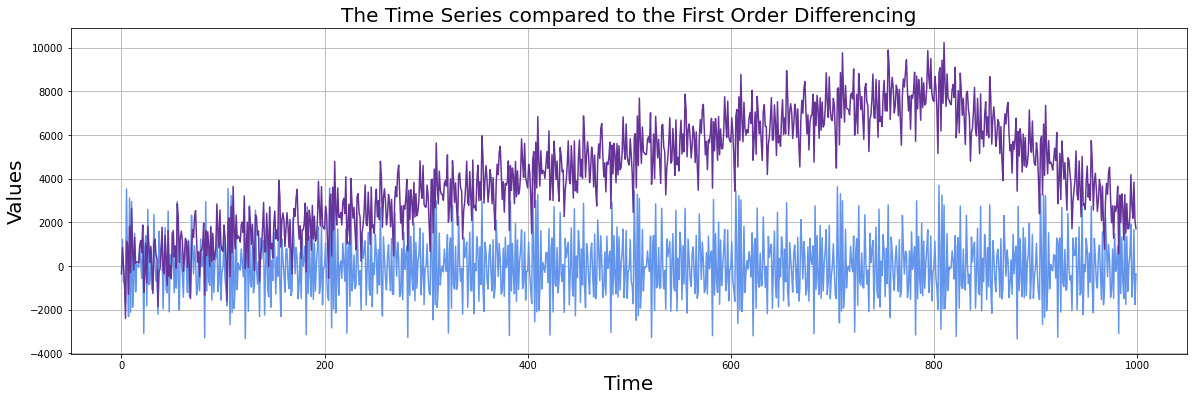

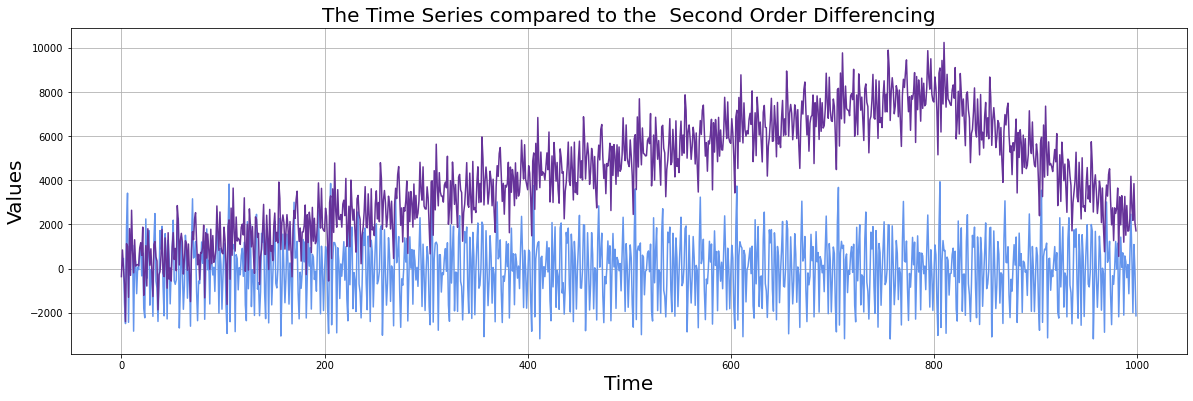

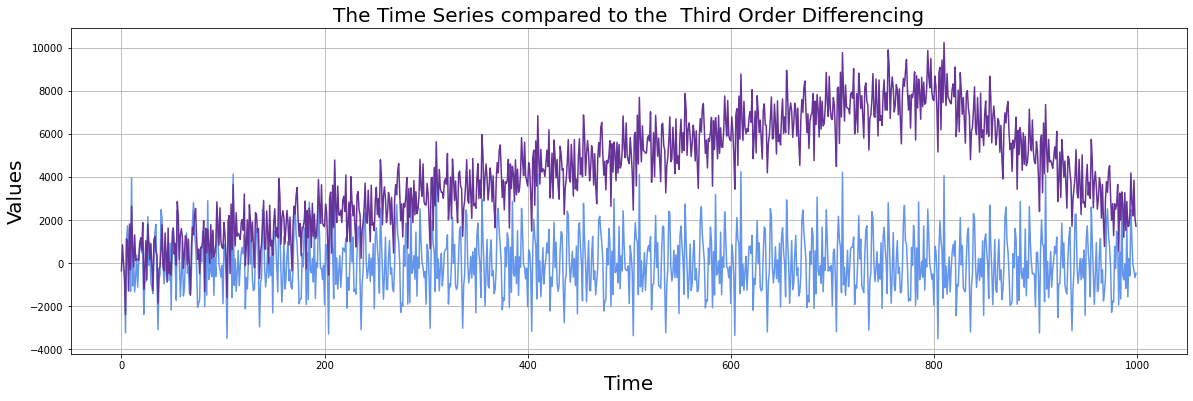

In [5]:
# differencing 
df_diff_1 = df.diff()
df_diff_2 = df.diff(periods=2)
df_diff_3 = df.diff(periods=3)
df['diff_1'] = df['values'].diff()
df['diff_2'] = df['values'].diff(periods=2)
df['diff_3'] = df['values'].diff(periods=3)

plot_time_series(time, df['diff_1'], label="The Time Series compared to the First Order Differencing")
plot_time_series(time, df['diff_2'], label="The Time Series compared to the  Second Order Differencing")
plot_time_series(time, df['diff_3'], label="The Time Series compared to the  Third Order Differencing")

In [6]:
# now we can test the new difirentiated columns of our data frame
adf_test(df['diff_1'].dropna(), "diff_1 column")
kpss_test(df['diff_1'].dropna(), "diff_1 column")
print()
adf_test(df['diff_2'].dropna(), "diff_2 column")
kpss_test(df['diff_2'].dropna(), "diff_2 column")
print()
adf_test(df['diff_3'].dropna(), "diff_3 column")
kpss_test(df['diff_3'].dropna(), "diff_3 column")

Results of Dickey-Fuller Test on:  diff_1 column
Test Statistic                -1.095968e+01
p-value                        8.387781e-20
#Lags Used                     2.000000e+01
Number of Observations Used    9.780000e+02
Critical Value (1%)           -3.437054e+00
Critical Value (5%)           -2.864500e+00
Critical Value (10%)          -2.568346e+00
dtype: float64
Results of KPSS Test on:  diff_1 column
Test Statistic            0.338612
p-value                   0.100000
Lags Used                49.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Results of Dickey-Fuller Test on:  diff_2 column
Test Statistic                -8.991557e+00
p-value                        6.869840e-15
#Lags Used                     2.200000e+01
Number of Observations Used    9.750000e+02
Critical Value (1%)           -3.437075e+00
Critical Value (5%)           -2.864509e+00
Critical Value

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


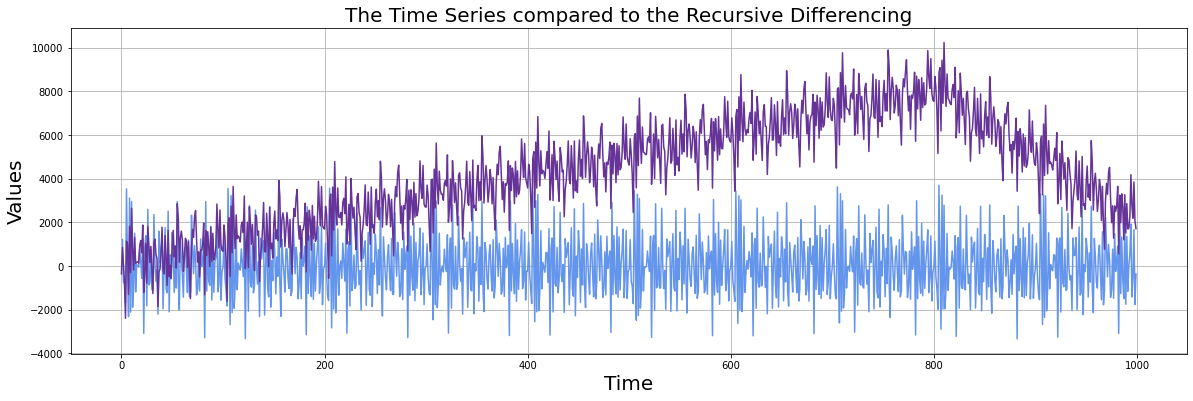

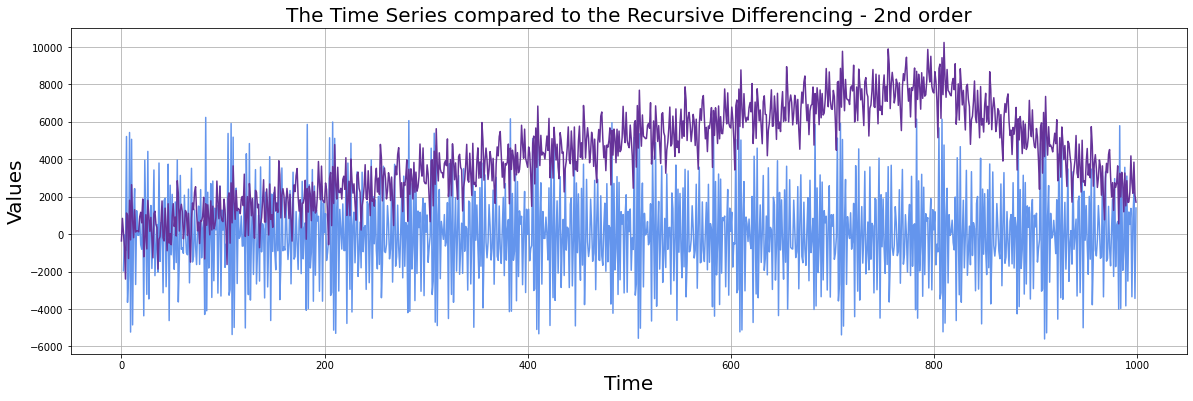

In [7]:
# Recursive Differencing
df['diff_o1'] = np.append(np.nan, np.diff(df['values']))
df['diff_o2'] = np.append([np.nan] * 2, np.diff(df['values'], n=2))

plot_time_series(time, df['diff_o1'], label="The Time Series compared to the Recursive Differencing")
plot_time_series(time, df['diff_o2'], label="The Time Series compared to the Recursive Differencing - 2nd order")

In [8]:
print('Testing ')
adf_test(df['diff_o1'].dropna(), "diff_o1 column")
kpss_test(df['diff_o1'].dropna(), "diff_o1 column")

adf_test(df['diff_o2'].dropna(), "diff_o2 column")
kpss_test(df['diff_o2'].dropna(), "diff_o2 column")

Testing 
Results of Dickey-Fuller Test on:  diff_o1 column
Test Statistic                -1.095968e+01
p-value                        8.387781e-20
#Lags Used                     2.000000e+01
Number of Observations Used    9.780000e+02
Critical Value (1%)           -3.437054e+00
Critical Value (5%)           -2.864500e+00
Critical Value (10%)          -2.568346e+00
dtype: float64
Results of KPSS Test on:  diff_o1 column
Test Statistic            0.338612
p-value                   0.100000
Lags Used                49.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of Dickey-Fuller Test on:  diff_o2 column
Test Statistic                -1.514750e+01
p-value                        6.871410e-28
#Lags Used                     2.200000e+01
Number of Observations Used    9.750000e+02
Critical Value (1%)           -3.437075e+00
Critical Value (5%)           -2.864509e+00
Cri

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


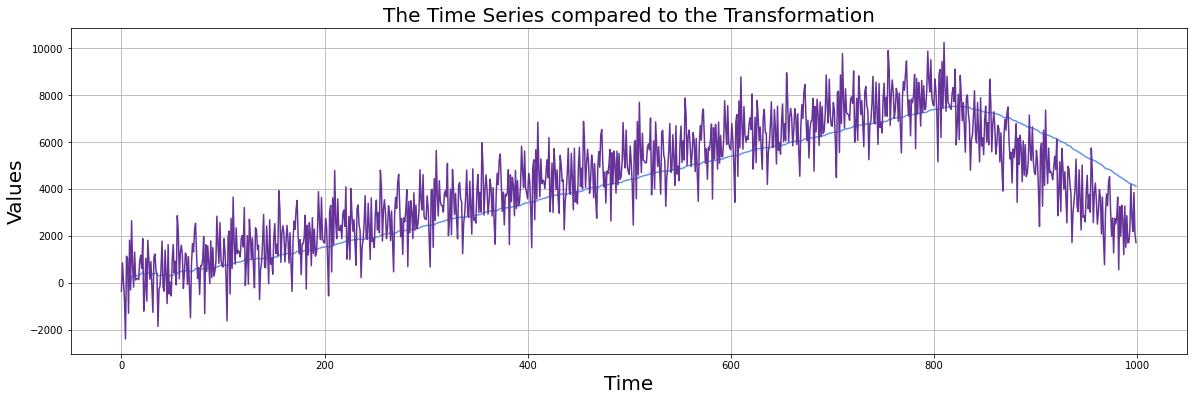

In [9]:
# Transformation applied to the original values
df['diff_t1'] = df['values'].ewm(halflife=50, min_periods=10, adjust=True).mean()

plot_time_series(time, df['diff_t1'], label="The Time Series compared to the Transformation")

In [10]:
adf_test(df['diff_t1'].dropna(), "diff_t1 column")
kpss_test(df['diff_t1'].dropna(), "diff_t1 column")

Results of Dickey-Fuller Test on:  diff_t1 column
Test Statistic                  -1.876845
p-value                          0.343031
#Lags Used                      22.000000
Number of Observations Used    968.000000
Critical Value (1%)             -3.437123
Critical Value (5%)             -2.864530
Critical Value (10%)            -2.568362
dtype: float64
Results of KPSS Test on:  diff_t1 column
Test Statistic            4.621461
p-value                   0.010000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


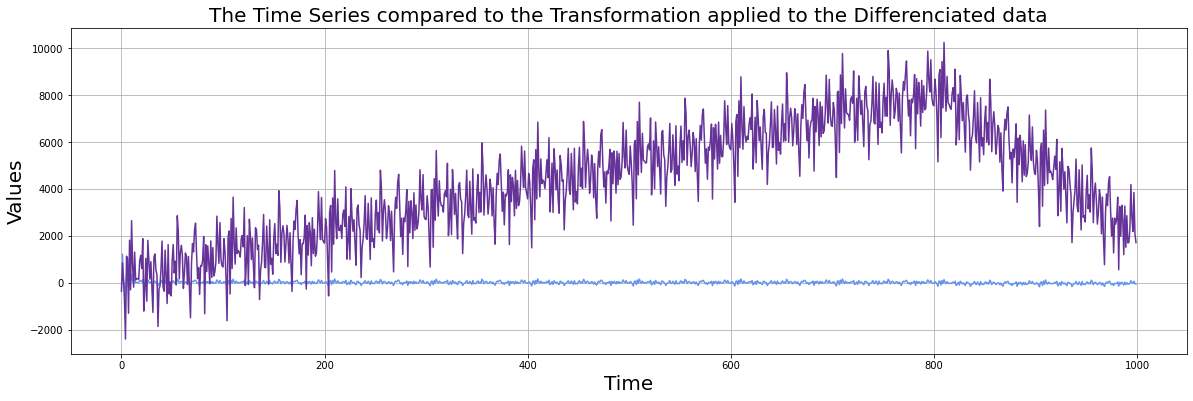

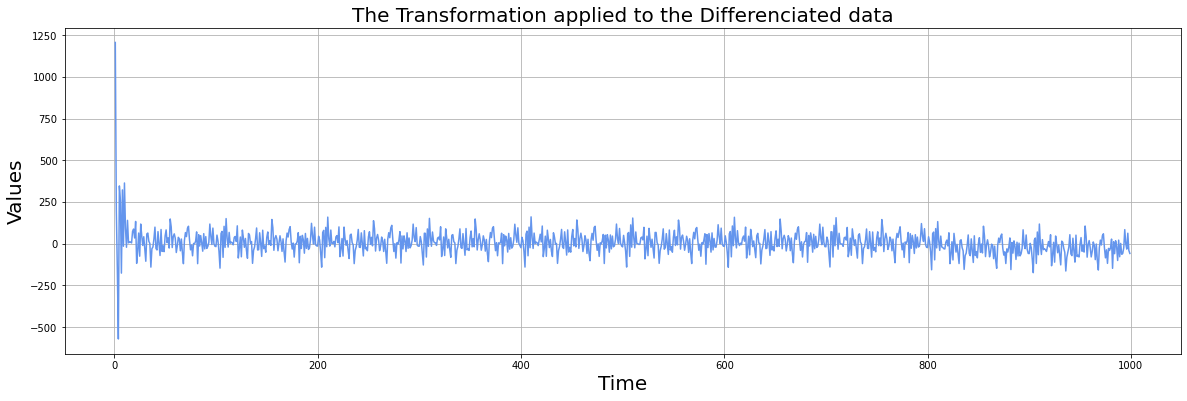

In [11]:
# Transformation applied to the original values
df['diff_t2'] = df['diff_1'].ewm(halflife=12, min_periods=0, adjust=True).mean()

plot_time_series(time, df['diff_t2'], label="The Time Series compared to the Transformation applied to the Differenciated data")

plt.figure(figsize=(20,6))
plt.plot(time, df['diff_t2'], color="cornflowerblue")
plt.xlabel("Time", fontsize=20)
plt.ylabel("Values", fontsize=20)
plt.title("The Transformation applied to the Differenciated data", fontsize=20)
plt.grid(True)

In [12]:
adf_test(df['diff_t2'].dropna(), "diff_t2 column")
kpss_test(df['diff_t2'].dropna(), "diff_t2 column")

Results of Dickey-Fuller Test on:  diff_t2 column
Test Statistic                  -4.342898
p-value                          0.000374
#Lags Used                      21.000000
Number of Observations Used    977.000000
Critical Value (1%)             -3.437061
Critical Value (5%)             -2.864503
Critical Value (10%)            -2.568348
dtype: float64
Results of KPSS Test on:  diff_t2 column
Test Statistic           3.061514
p-value                  0.010000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


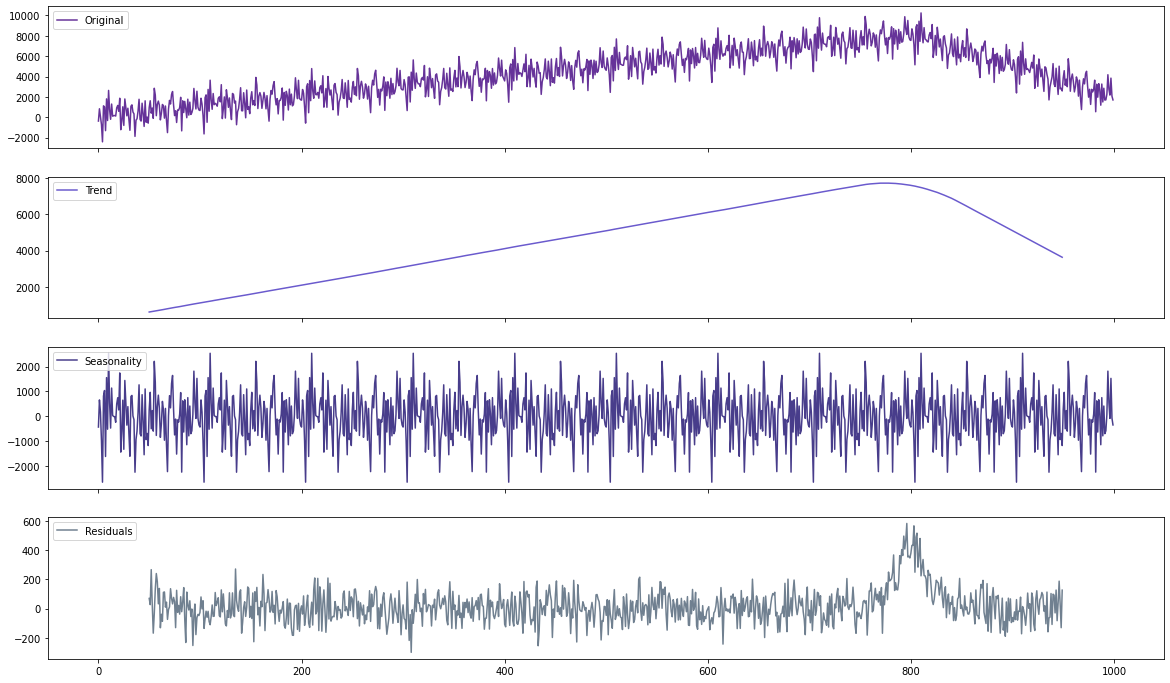

In [13]:
# decompositions
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(df['values'], model='additive', period=100)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(12)
fig.set_figwidth(20)

axes[0].plot(df['values'], label='Original', color='rebeccapurple')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend', color='slateblue')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality', color='darkslateblue')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals', color='slategrey')
axes[3].legend(loc='upper left');


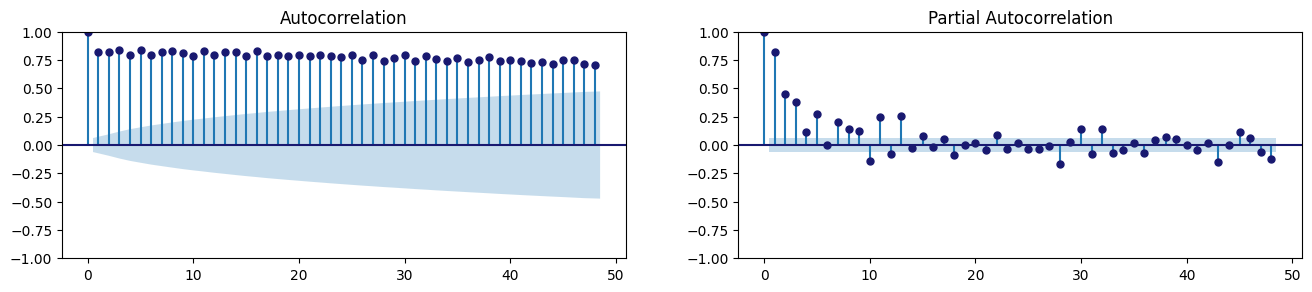

In [14]:
#### from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['values'], lags=48, ax=axes[0], color='midnightblue')
plot_pacf(df['values'], lags=48, ax=axes[1], method='ywm', color='midnightblue')
plt.show()


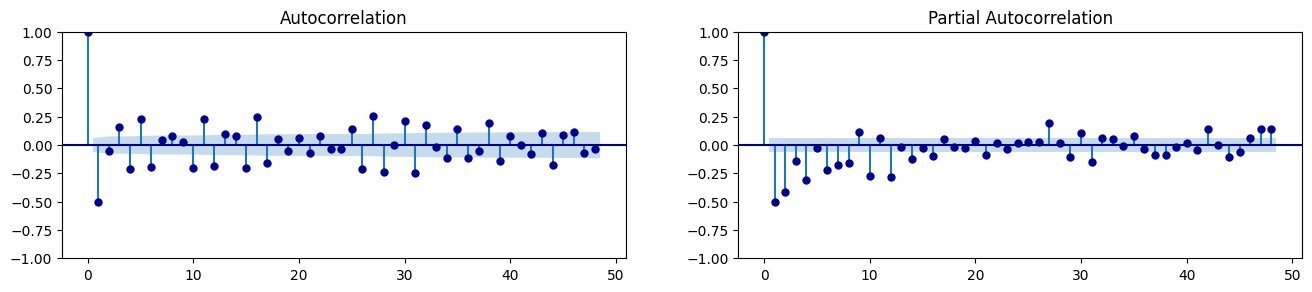

In [15]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['diff_1'].dropna(), lags=48, ax=axes[0], color='darkblue')
plot_pacf(df['diff_1'].dropna(), lags=48, ax=axes[1], method='ywm', color='darkblue')
plt.show()

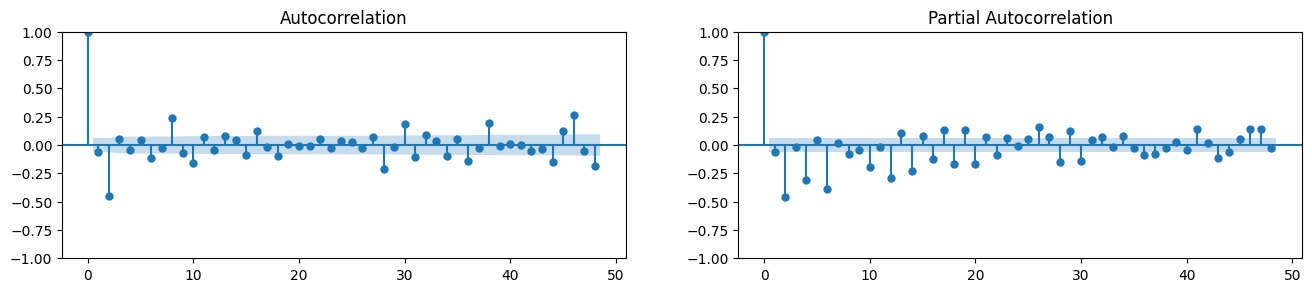

In [16]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['diff_2'].dropna(), lags=48, ax=axes[0])
plot_pacf(df['diff_2'].dropna(), method='ywm', lags=48, ax=axes[1])
plt.show()

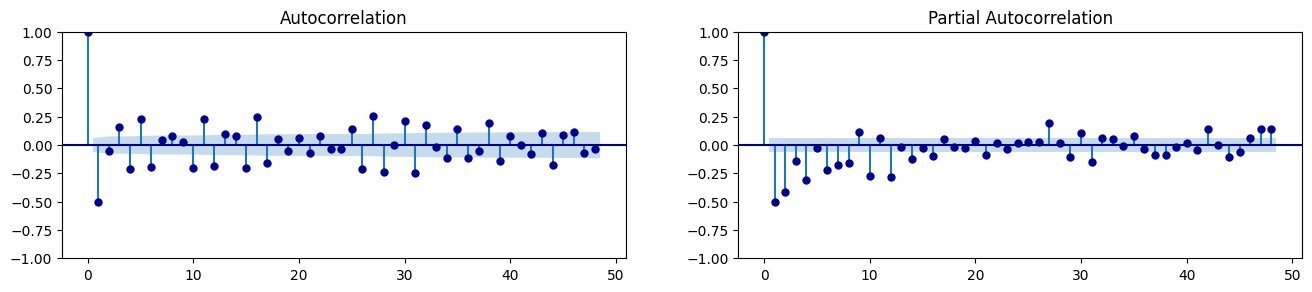

In [17]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['diff_o1'].dropna(), lags=48, ax=axes[0], color='darkblue')
plot_pacf(df['diff_o1'].dropna(), lags=48, ax=axes[1], method='ywm', color='darkblue')
plt.show()

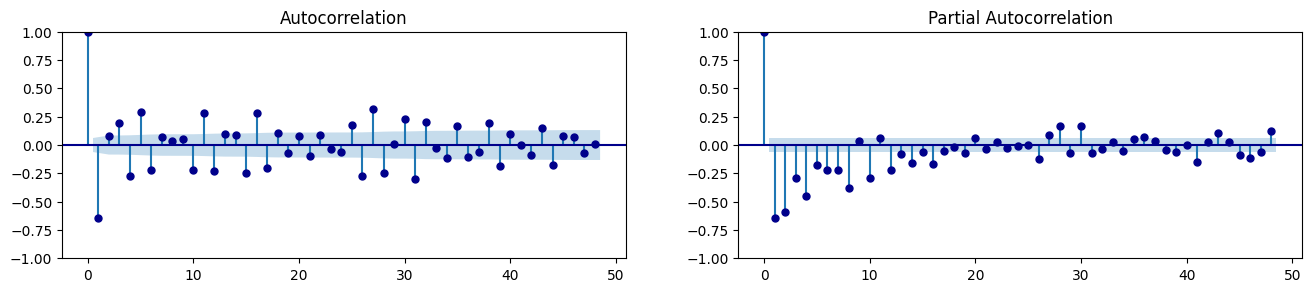

In [18]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['diff_o2'].dropna(), lags=48, ax=axes[0], color='darkblue')
plot_pacf(df['diff_o2'].dropna(), lags=48, ax=axes[1], method='ywm', color='darkblue')
plt.show()

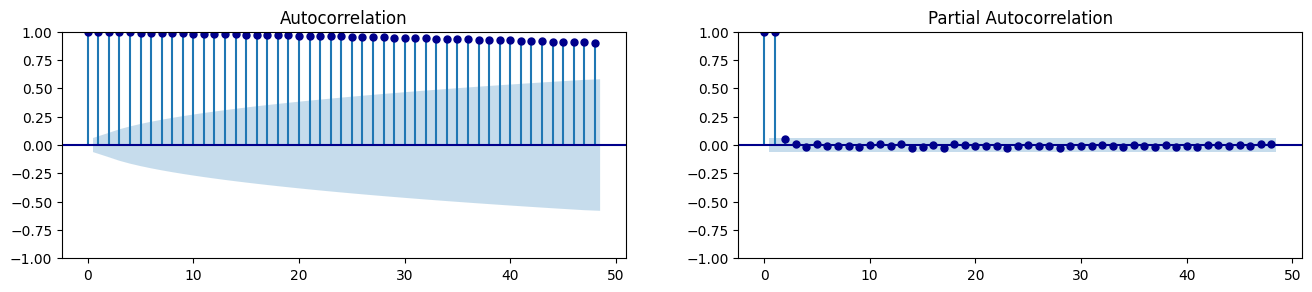

In [19]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['diff_t1'].dropna(), lags=48, ax=axes[0], color='darkblue')
plot_pacf(df['diff_t1'].dropna(), lags=48, ax=axes[1], method='ywm', color='darkblue')
plt.show()

## Autoregression (AR)

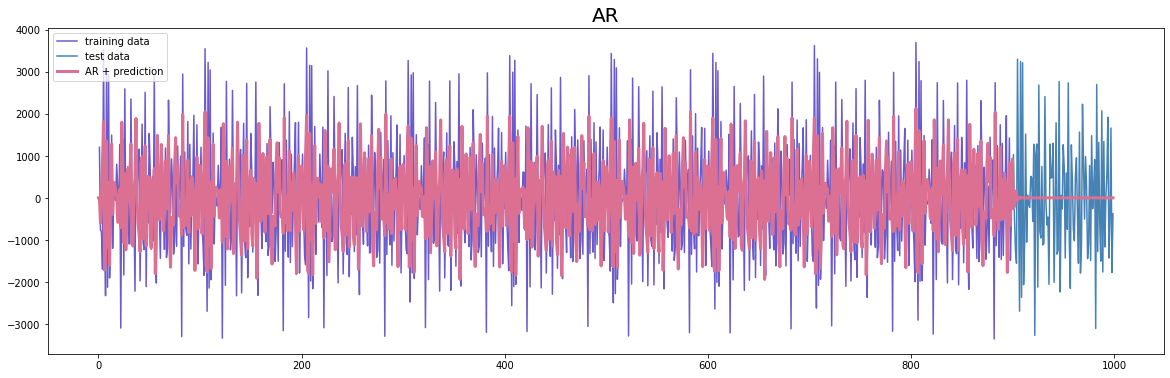

In [20]:
# Create training and test data
train_data = df['diff_1'][:len(df)-100]
test_data = df['diff_1'][len(df)-100:]

# Instantiate and fit the AR model with training data
ar_model = ARIMA(train_data, order=(3, 0, 0))
ar_model = ar_model.fit()

# Make the predictions
pred = ar_model.predict(end=(len(df)-1))

# Plot the prediction vs test data
plt.figure(figsize=(20,6))
# plt.plot(df['values'], color='rebeccapurple', label='original purple')
plt.title("AR", fontsize=20)
plt.plot(train_data, color='slateblue', label='training data')
plt.plot(time[-100:], test_data, color='steelblue', label='test data')
plt.plot(pred, color='palevioletred', label='AR + prediction', linewidth=3)
plt.legend(loc="upper left")
plt.show()

## MA

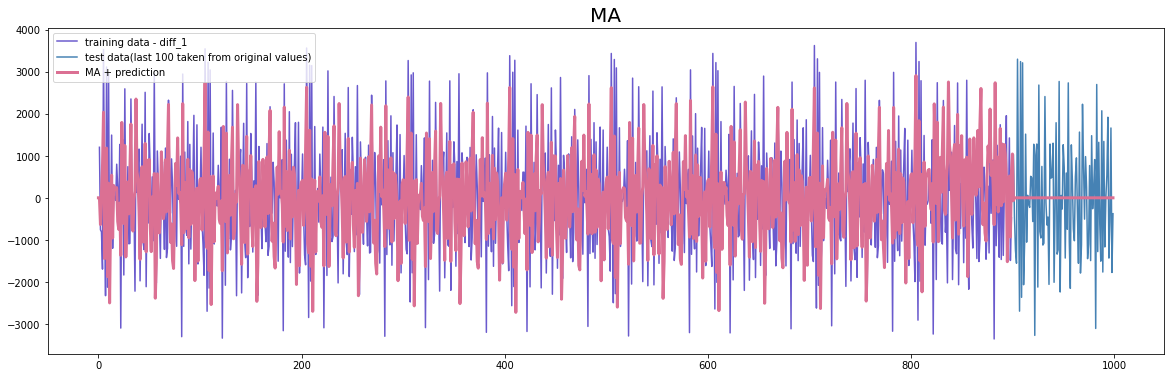

In [21]:
# Instantiate and fit the MA model with training data
ma_model = ARIMA(train_data, order=(0, 0, 2))
ma_model = ma_model.fit()

# Make the predictions
pred = ma_model.predict(end=(len(df)-1))

# Plot the prediction vs test data
plt.figure(figsize=(20,6))
plt.title("MA", fontsize=20)
# plt.plot(df['values'], color='rebeccapurple', label='original purple')
plt.plot(train_data, color='slateblue', label='training data - diff_1')
plt.plot(time[-100:], test_data, color='steelblue', label='test data(last 100 taken from original values)')
plt.plot(pred, color='palevioletred', label='MA + prediction', linewidth=3)
plt.legend(loc="upper left")
plt.show()


## ARMA

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


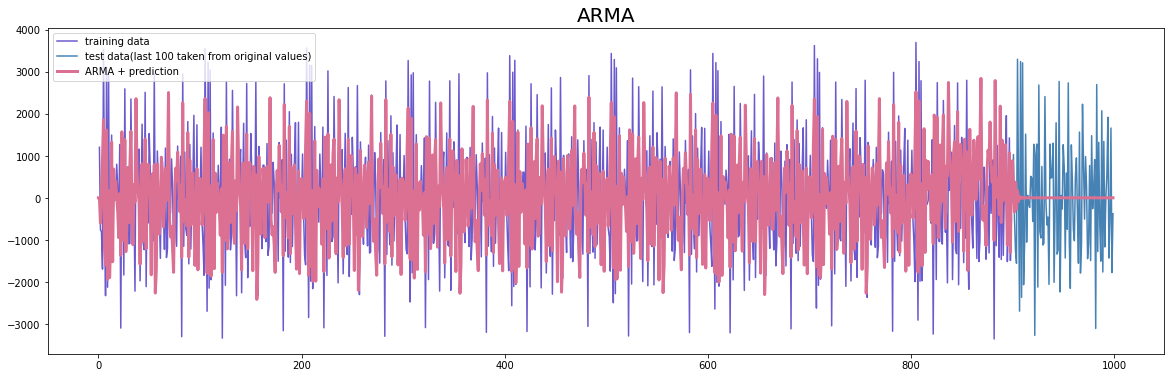

In [22]:
# # ARMA example
arma_model = ARIMA(train_data, order=(3, 0, 2))
arma_model = arma_model.fit()

# Make the predictions
pred = arma_model.predict(end=(len(df)-1))

# Plot the prediction vs test data
plt.figure(figsize=(20,6))
plt.title("ARMA", fontsize=20)
# plt.plot(df['values'], color='rebeccapurple', label='original purple')
plt.plot(train_data, color='slateblue', label='training data')
plt.plot(time[-100:], test_data, color='steelblue', label='test data(last 100 taken from original values)')
plt.plot(pred, color='palevioletred', label='ARMA + prediction', linewidth=3)
plt.legend(loc="upper left")
plt.show()

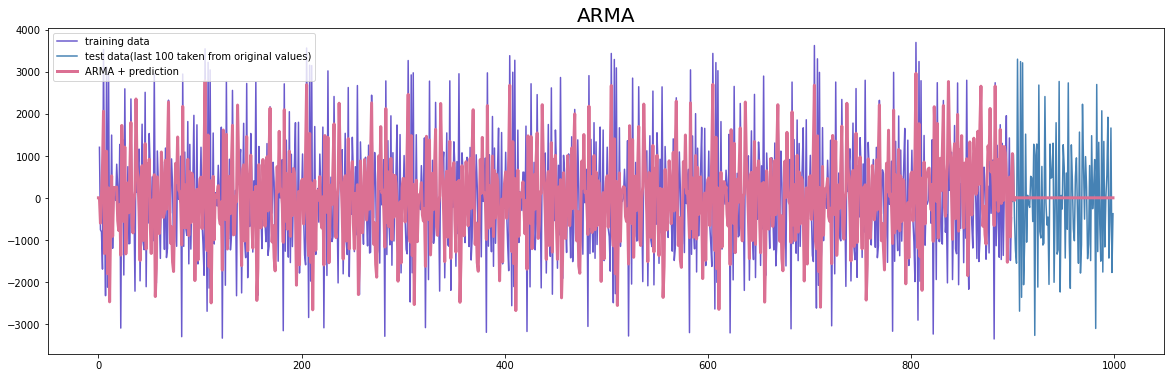

In [23]:
# # ARMA example
arma_model = ARIMA(train_data, order=(2, 0, 1))
arma_model = arma_model.fit()

# Make the predictions
pred = arma_model.predict(end=(len(df)-1))

# Plot the prediction vs test data
plt.figure(figsize=(20,6))
plt.title("ARMA", fontsize=20)
# plt.plot(df['values'], color='rebeccapurple', label='original purple')
plt.plot(train_data, color='slateblue', label='training data')
plt.plot(time[-100:], test_data, color='steelblue', label='test data(last 100 taken from original values)')
plt.plot(pred, color='palevioletred', label='ARMA + prediction', linewidth=3)
plt.legend(loc="upper left")
plt.show()

## ARIMA

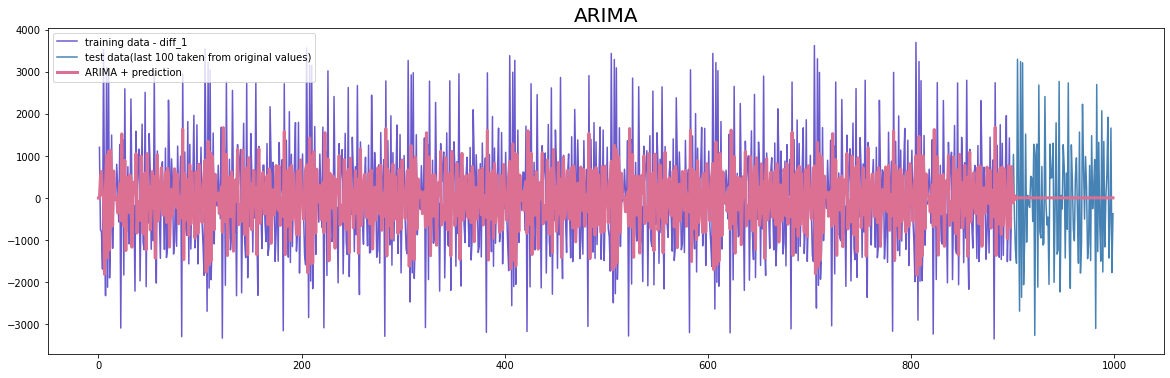

In [24]:
arima_model = ARIMA(train_data, order=(1, 1, 1))
arima_model = arima_model.fit()

# Make the predictions
pred = arima_model.predict(end=(len(df)-1))

# Plot the prediction vs test data
plt.figure(figsize=(20,6))
plt.title("ARIMA", fontsize=20)
# plt.plot(df['values'], color='rebeccapurple', label='original purple')
plt.plot(train_data, color='slateblue', label='training data - diff_1')
plt.plot(time[-100:], test_data, color='steelblue', label='test data(last 100 taken from original values)')
plt.plot(pred, color='palevioletred', label='ARIMA + prediction', linewidth=3)
plt.legend(loc="upper left")
plt.show()

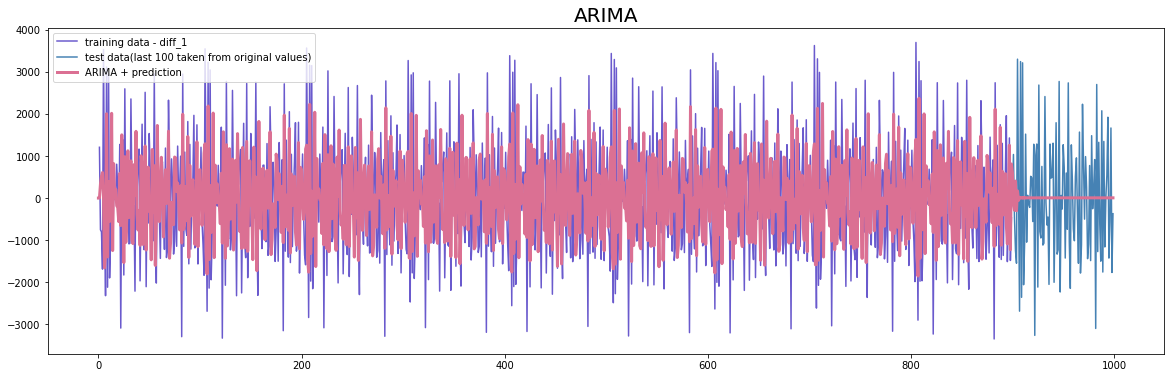

In [25]:
arima_model = ARIMA(train_data, order=(3, 1, 2))
arima_model = arima_model.fit()

# Make the predictions
pred = arima_model.predict(end=(len(df)-1))

# Plot the prediction vs test data
plt.figure(figsize=(20,6))
plt.title("ARIMA", fontsize=20)
# plt.plot(df['values'], color='rebeccapurple', label='original purple')
plt.plot(train_data, color='slateblue', label='training data - diff_1')
plt.plot(time[-100:], test_data, color='steelblue', label='test data(last 100 taken from original values)')
plt.plot(pred, color='palevioletred', label='ARIMA + prediction', linewidth=3)
plt.legend(loc="upper left")
plt.show()

## SARIMA

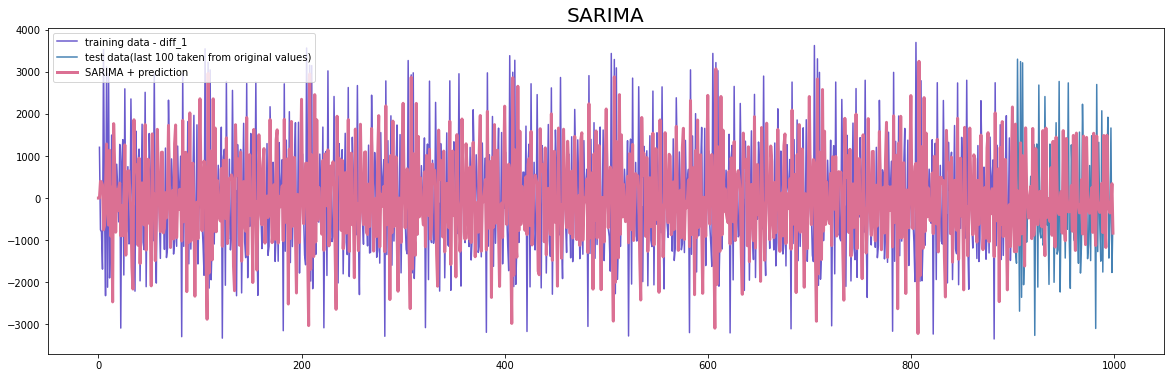

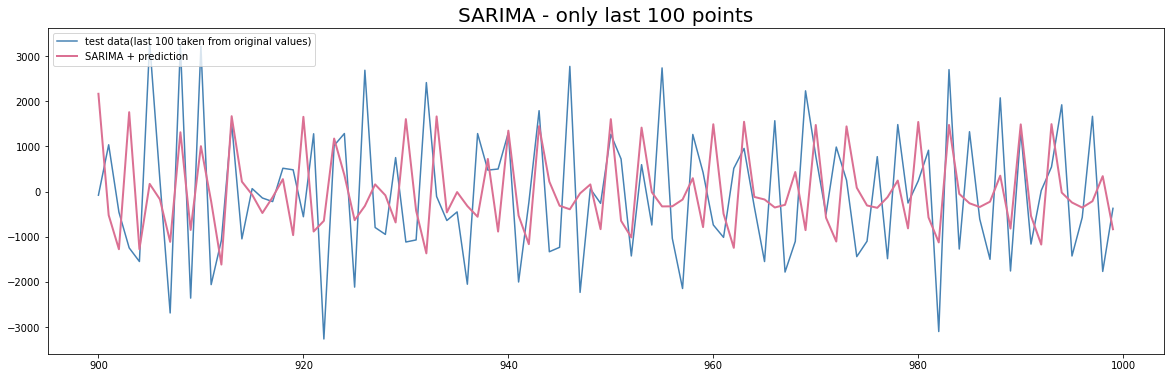

In [26]:
# SARIMA example

# fit model
model = SARIMAX(train_data, order=(3, 1, 2), seasonal_order=(2, 1, 0, 10))
model_fit = model.fit(disp=False)

# make prediction
pred = model_fit.predict(end=(len(df)-1))

# Plot the prediction vs test data
plt.figure(figsize=(20,6))
plt.title("SARIMA", fontsize=20)
plt.plot(train_data, color='slateblue', label='training data - diff_1')
plt.plot(time[-100:], test_data, color='steelblue', label='test data(last 100 taken from original values)')
plt.plot(pred, color='palevioletred', label='SARIMA + prediction', linewidth=3)
plt.legend(loc="upper left")
plt.show()


# test v prediction close up
plt.figure(figsize=(20,6))
plt.title("SARIMA - only last 100 points", fontsize=20)
plt.plot(time[-100:], test_data, color='steelblue', label='test data(last 100 taken from original values)')
plt.plot(time[-100:], pred[-100:], color='palevioletred', label='SARIMA + prediction', linewidth=2)
plt.legend(loc="upper left")
plt.show()


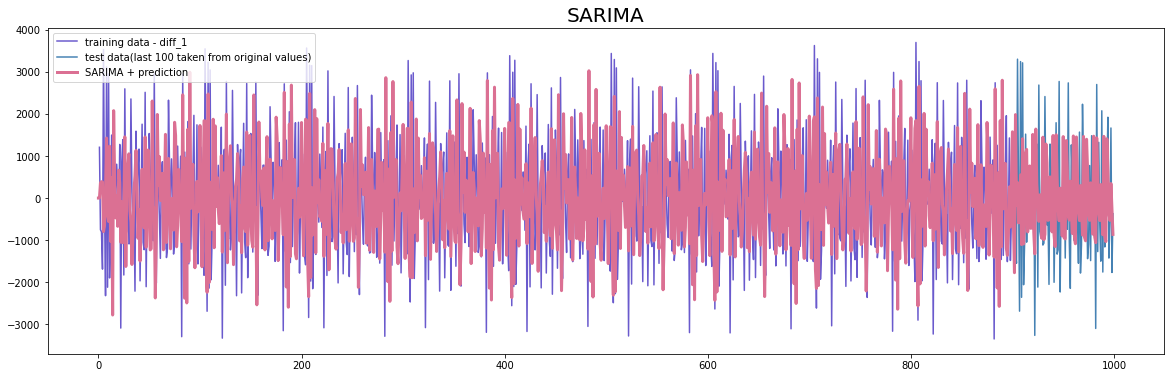

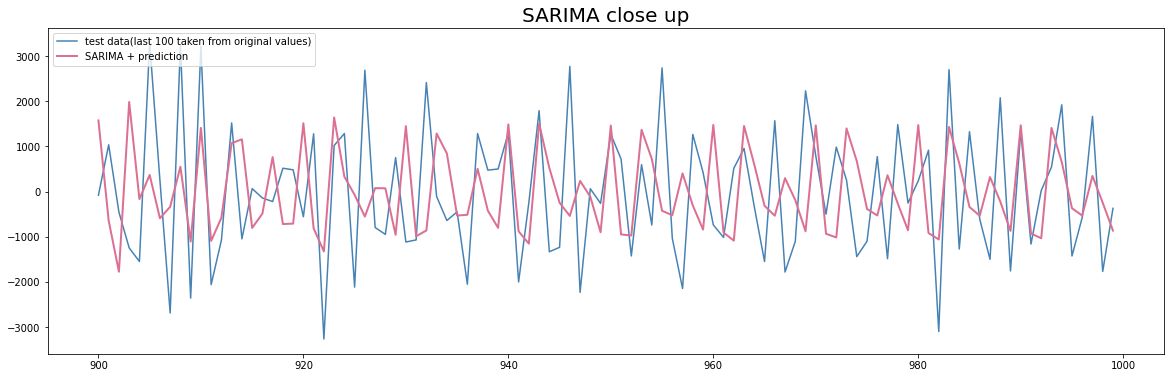

In [27]:
# SARIMA example

# fit model
model = SARIMAX(train_data, order=(3, 1, 2), seasonal_order=(1, 1, 0, 10))
model_fit = model.fit(disp=False)

# make prediction
pred = model_fit.predict(end=(len(df)-1))

# Plot the prediction vs test data
plt.figure(figsize=(20,6))
plt.title("SARIMA", fontsize=20)
plt.plot(train_data, color='slateblue', label='training data - diff_1')
plt.plot(time[-100:], test_data, color='steelblue', label='test data(last 100 taken from original values)')
plt.plot(pred, color='palevioletred', label='SARIMA + prediction', linewidth=3)
plt.legend(loc="upper left")
plt.show()


# test v prediction close up
plt.figure(figsize=(20,6))
plt.title("SARIMA close up", fontsize=20)
plt.plot(time[-100:], test_data, color='steelblue', label='test data(last 100 taken from original values)')
plt.plot(time[-100:], pred[-100:], color='palevioletred', label='SARIMA + prediction', linewidth=2)
plt.legend(loc="upper left")
plt.show()

## ML

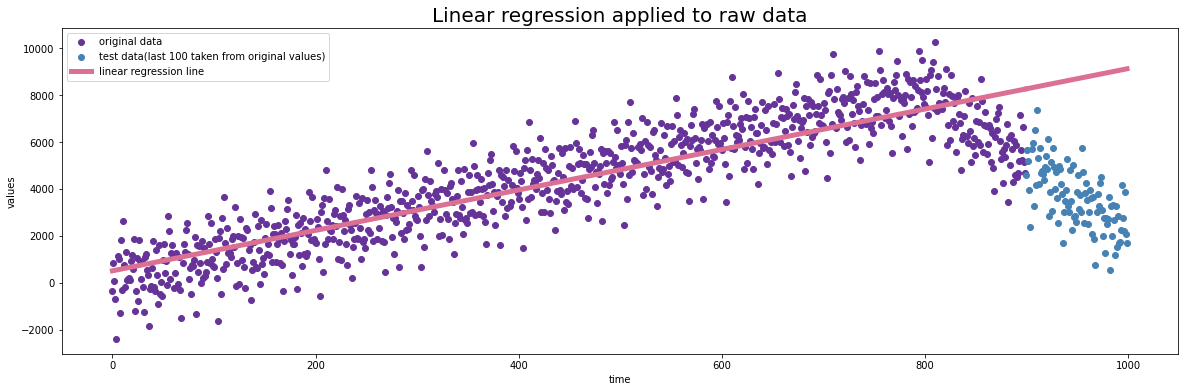

In [28]:
X = time
y = df['values']

X_train = X[:len(df)-100]
X_test = X[len(df)-100:]
Y_train = y[:len(df)-100]
Y_test = y[len(df)-100:]

regressor=LinearRegression()  
regressor.fit(X_train.reshape(-1, 1),Y_train.values.reshape(-1,1))  
y_pre=regressor.predict(X_test.reshape(-1, 1))

plt.figure(figsize=(20,6))
plt.scatter(X_train, Y_train, color = "rebeccapurple", label='original data')
plt.scatter(time[-100:],Y_test, color='steelblue', label='test data(last 100 taken from original values)')
plt.plot(X_train, regressor.predict(X_train.reshape(-1, 1)), color = "palevioletred", linewidth=5, label='linear regression line')
plt.plot(X_test, y_pre, color = "palevioletred", linewidth=5)
plt.title("Linear regression applied to raw data", fontsize=20)
plt.xlabel("time")
plt.ylabel("values")
plt.legend(loc="upper left")
plt.show()

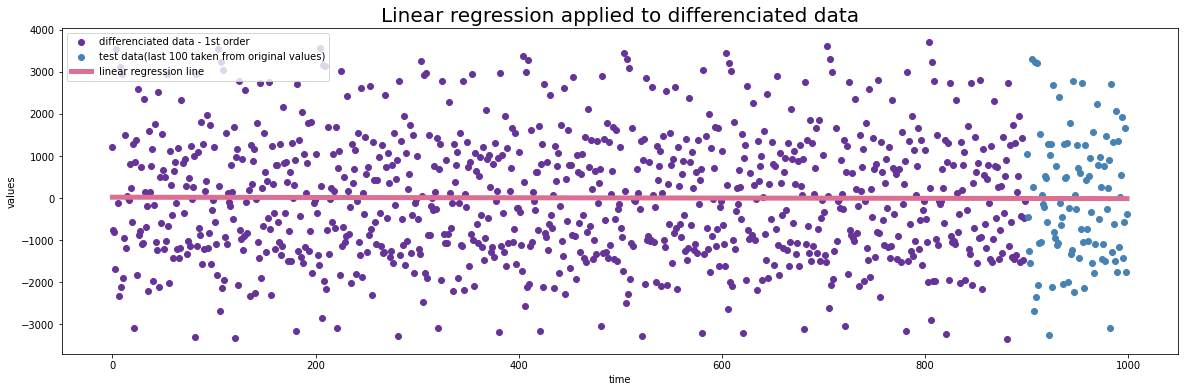

In [29]:
X = time  # put your dates in here
y = df['diff_1'].dropna()  # put your kwh in here

X_train = X[:len(df)-100]
X_test = X[len(df)-100:]
Y_train = y[:len(df)-100]
Y_test = y[len(df)-100:]

regressor=LinearRegression()  
regressor.fit(X_train.reshape(-1, 1),Y_train.values.reshape(-1,1))  
y_pre=regressor.predict(X_test.reshape(-1, 1))
# print(y_pre)
# print(Y_test.count())
plt.figure(figsize=(20,6))
plt.scatter(X_train, Y_train, color = "rebeccapurple", label='differenciated data - 1st order')
plt.scatter(time[-99:],Y_test, color='steelblue', label='test data(last 100 taken from original values)')
# plt.scatter(X_test,Y_test, color='steelblue', label='test data(last 100 taken from original values)')
plt.plot(X_train, regressor.predict(X_train.reshape(-1, 1)), color = "palevioletred", linewidth=5, label='linear regression line')
plt.plot(X_test, y_pre, color = "palevioletred", linewidth=5)
plt.title("Linear regression applied to differenciated data", fontsize=20)
plt.xlabel("time")
plt.ylabel("values")
plt.legend(loc="upper left")
plt.show()


***

## XGBOOST

### see part two of this notebook

https://www.kaggle.com/werakaggle/time-series-forecasting-methods-part-ii-xgboost

## LSTM
### see part III of this notebook
https://www.kaggle.com/werakaggle/time-series-forecasting-methods-part-iii-lstm


 ***

 
**References:**

Lectures provided by Huddersfield University - AI Skills Bootcamp - [S.M. Riazul Islam, PhD](http://www.riazulislam.com/)

Soner Yıldırım. Towards Data Science. (2020). *Time Series Analysis: Creating Synthetic Datasets.* https://towardsdatascience.com/time-series-analysis-creating-synthetic-datasets-cf008208e014

Aishwarya Singh . Analytics Vidhya. (2018). *A Gentle Introduction to Handling a Non-Stationary Time Series in Python.* https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/

Jason Brownlee. Machine Learning Mastery. (2017). *How to Difference a Time Series Dataset with Python.* https://machinelearningmastery.com/difference-time-series-dataset-python/

Eriy Lewinson. Towards Data Science. (2020). *An intuitive guide to differencing time series in Python.* https://towardsdatascience.com/an-intuitive-guide-to-differencing-time-series-in-python-1d6c7a2c067a

Selva Prabhakaran. Machine Learning Plus. (2019). *Time Series Analysis in Python – A Comprehensive Guide with Examples.* https://www.machinelearningplus.com/time-series/time-series-analysis-python/

Jason Brownlee. Machine Learning Mastery. (2018). *11 Classical Time Series Forecasting Methods in Python (Cheat Sheet).* https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

Jason Brownlee. Machine Learning Mastery. (2018). *A Gentle Introduction to SARIMA for Time Series Forecasting in Python.* https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/

Mat Plot Lib. (2022). *List of named colors. matplotlib.* https://matplotlib.org/stable/gallery/color/named_colors.html

R J Hyndman, G Athanasopoulos. Monash University, Australia. (2021). *Chapter 6 Time series decomposition.* https://otexts.com/fpp2/decomposition.html

Weronika Limberger. (2022). *ML Spam Filters.* https://www.kaggle.com/code/werakaggle/ml-spam-filters

Jason Brownlee. Machine Learning Mastery. (2020). *How to Use XGBoost for Time Series Forecasting.* https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

Jason Brownlee. Machine Learning Mastery. (2022). *Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras.* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/